# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [8]:
# Load pickled data
import pickle

path = "/home/carnd/SDCND-Term1-TrafficSign/traffic-signs-data/"
#path="/Users/joergsimon/Dropbox/uni/SDCND/SDCND-Term1-TrafficSign/traffic-signs-data/"
training_file = path + "train.p"
validation_file= path + "valid.p"
testing_file = path + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
n_train = y_train.size
n_valid = y_valid.size
n_test = y_test.size
image_shape = X_train[0].shape[0:2]
all_y = np.concatenate((y_train,y_valid,y_test))
all_lbls = np.unique(all_y)
n_classes = all_lbls.size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

23


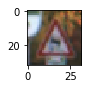

In [9]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

In [4]:
def get_channel_histogram(channel_num):
    channel_histogram = np.zeros(256)
    for i in range(len(X_train)):
        img_data = X_train[i]
        for x in range(32):
            for y in range(32):
                val = img_data[x][y][channel_num]
                channel_histogram[val] = channel_histogram[val] + 1
    return channel_histogram

c1_hist = get_channel_histogram(0)
c2_hist = get_channel_histogram(1)
c3_hist = get_channel_histogram(2)

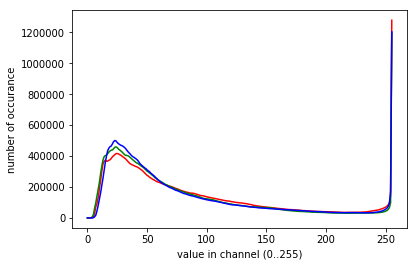

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(c1_hist, "r")
ax.plot(c2_hist, "g")
ax.plot(c3_hist, "b")
plt.xlabel('value in channel (0..255)')
plt.ylabel('number of occurance')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
from sklearn.utils import shuffle
import tensorflow as tf
EPOCHS = 15
BATCH_SIZE = 128
X_train, y_train = shuffle(X_train, y_train)

In [21]:
# check if we are running on gpu's:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [11]:
import cv2
def convertToGrayscale(data):
    grey_data = np.ndarray((data.shape[0], 32, 32, 1), dtype=np.uint8)
    for i in range(data.shape[0]):
        img = data[i].squeeze()
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image = np.expand_dims(gray_image, axis=2)
        grey_data[i] = gray_image
    return grey_data

g = convertToGrayscale(X_train)
X_train = g

g = convertToGrayscale(X_valid)
X_valid = g

g = convertToGrayscale(X_test)
X_test = g

35


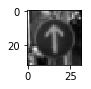

In [12]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

image = X_train[index]
image = image.reshape(image.shape[:-1])

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

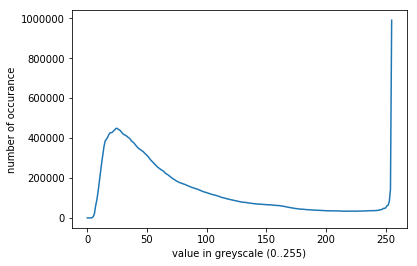

In [9]:
c1_hist_grey = get_channel_histogram(0)
fig, ax = plt.subplots(1,1)
ax.plot(c1_hist_grey)
plt.xlabel('value in greyscale (0..255)')
plt.ylabel('number of occurance')
plt.show()

### Model Architecture

In [13]:
from tensorflow.contrib.layers import flatten
#from tensorflow.python import control_flow_ops

batch_size = BATCH_SIZE

def conv2d(input, weight_dim, num_biases, strides_dim=[1,1,1,1], padding = 'SAME'):
    # Filter (weights and bias)
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,)
    # stride for each dimension (batch_size, height, width, depth)
    mu = 0
    sigma = 0.1
    F_W = tf.Variable(tf.truncated_normal(weight_dim, mu, sigma))
    F_b = tf.Variable(tf.truncated_normal(num_biases, mu, sigma))
    strides = strides_dim
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # `tf.nn.conv2d` does not include the bias computation so we have to add it ourselves after.
    return tf.nn.bias_add(tf.nn.conv2d(input, F_W, strides, padding),F_b)

def activation(input):
    return tf.nn.relu(input)

def maxpool(input, ksize, strides, padding = 'VALID'):
    # ksize (filter size) for each dimension (batch_size, height, width, depth)
    # stride for each dimension (batch_size, height, width, depth)
    
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#max_pool
    return tf.nn.max_pool(input, ksize, strides, padding)

def connectedL(input, in_dim, out_dim):
    mu = 0
    sigma = 0.1
    weights = tf.Variable(tf.truncated_normal([in_dim, out_dim], mu, sigma))
    biases = tf.Variable(tf.truncated_normal([out_dim], mu, sigma))
    return tf.add(tf.matmul(input, weights),biases)

# taken from http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
def batch_norm(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def batch_norm_fullyc(x, n_out, phase_train, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def batch_normf(x, phase_train=False, reuse=None, scope=None):
    return tf.contrib.layers.batch_norm(x, is_training=phase_train, reuse=reuse, scope=scope, updates_collections=None, decay=0.9, center=True, scale=True)

def debug_dim(thingwithshape, is_debug_on):
    if is_debug_on:
        if hasattr(thingwithshape, 'shape'):
            print(thingwithshape.shape)
        elif hasattr(thingwithshape, 'get_shape'):
            print (thingwithshape.get_shape())
        else:
            print("could not get shape:")
            print(thingwithshape)

#### Le Net Model
As a starting point for the project in the videos the Le Net Model was suggested. Only small variations of the the Le Net Model needed to be done like changing the input and output dimension size. This is the version with the minimal amount of variations.

In [11]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = False
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1 = conv2d(x, [5,5,1,6], [6])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    # Layer 2: 
    # Convolutional. Output = 10x10x16.
    c2 = conv2d(p1, [5,5,6,16], [16])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    # Flatten. Input = 5x5x16. Output = 400.
    f = flatten(p2)
    debug_dim(f, debug_dimension)
    # Layer 3: 
    # Fully Connected. Input = 400. Output = 120.
    c3 = connectedL(f, 400, 120)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    c4 = connectedL(a3, 120, 84)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    c5 = connectedL(a4, 84, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits

#### Sermanet & LeCun Model
this is the model described in "Traffic sign recognition with multi-scale Convolutional Networks" 2011. However, several parameters are not exactly specified in the paper, for example:
* the size of the convolution filter (only the depth is described). Here I first tried with the sizes we also have in LeNet.
* the type of pooling layer: that paper states it uses a spatial feature pooling layer, but does not descripe it in detail, I use max pooling instead as it is recommendet in http://cs231n.github.io/convolutional-networks/
* the non-linear transform layer: instead of a ReLU activation the paper states to use a own local normalization function. I might also have gotten that wrong. Again I use the std. ReLU as suggested in http://cs231n.github.io/convolutional-networks/

Beside the other rational of the coices it seems also that these Filters are used from both in the more recent OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks Model

In [35]:
def sermant_lecun(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = True
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x108.
    c1 = conv2d(x, [5,5,1,108], [108])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    # Pooling. Input = 28x28x108. Output = 14x14x108.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    
    # Layer 2: 
    # Convolutional. Input = 14x14x108. Output = 10x10x200.
    c2 = conv2d(p1, [5,5,108,200], [200])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x200. Output = 5x5x200.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    
    # Layer 3:
    # flatten Layer 1 & Layer 2 and concatenate, giving 21168 + 5000 = 26168
    f1 = flatten(p1)
    debug_dim(f1, debug_dimension)
    f2 = flatten(p2)
    debug_dim(f2, debug_dimension)
    f = tf.concat(1,(f1,f2))
    debug_dim(f, debug_dimension)
    # Fully Connected. Input = 26168. Output = 200.
    c3 = connectedL(f, 26168, 200)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    
    # Layer 4:
    # Fully Connected. Input = 200. Output = 100.
    c4 = connectedL(a3, 200, 100)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    
    # Layer 5: 
    # Fully Connected. Input = 100. Output = 43.
    c5 = connectedL(a4, 100, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits
    

#### Sermanet LeCun Adoptions

The Semanet and LeCun Network the way I understood it did not work well. I guess there are many things open for interpretation. One way to look at the network is to see it as a LeNet network with the output of the first and second layer coupled together. Additionally more conv layers with iterative deeper features seem to work good. On the other hand when connecting all the intermediate layers we want the global features to be dominant, but usually you have most of the local features. Because of that each layer has two poolings, one for the next layer, one for the connection of all of them to have siutable sizes. This architecture is a trial of that.

In [64]:
def LeNet_l1andl2connected(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # print debug dimensions
    debug_dimension = True
    
    # Layer 1: 
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1 = conv2d(x, [5,5,1,6], [6])
    debug_dim(c1, debug_dimension)
    # Activation.
    a1 = activation(c1)
    debug_dim(a1, debug_dimension)
    
    # Pooling 1 will be used for the next step of convolutions
    # but since we combine the output of pooling 1 and pooling 2
    # we want to have a balanced number of features of lower and
    # higher level invariants. with directly feeding the response
    # of pooling 1 into the fully connected, we end up with giving lower
    # level features more weight. So we use a second pooling filter
    # to go over the data and use that
    
    # Pooling 1. Input = 28x28x6. Output = 14x14x6.
    p1 = maxpool(a1, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p1, debug_dimension)
    # Pooling 2. Input = 28x28x6. Output = 7x7x6.
    p1_l4 = maxpool(a1, [1, 5, 5, 1], [1, 5, 5, 1])
    debug_dim(p1_l4, debug_dimension)
    
    # Layer 2: 
    # Convolutional. Output = 10x10x16.
    c2 = conv2d(p1, [5,5,6,16], [16])
    debug_dim(c2, debug_dimension)
    # Activation.
    a2 = activation(c2)
    debug_dim(a2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = maxpool(a2, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p2, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2_l4 = maxpool(a2, [1, 3, 3, 1], [1, 3, 3, 1])
    debug_dim(p2_l4, debug_dimension)
    
    # Layer 3: 
    # Convolutional. Output = 4x4x32.
    c_3 = conv2d(p2, [2,2,16,32], [32])
    debug_dim(c_3, debug_dimension)
    # Activation.
    a_3 = activation(c_3)
    debug_dim(a_3, debug_dimension)
    # Pooling. Input = 10x10x16. Output = 2x2x32.
    p_3 = maxpool(a_3, [1, 2, 2, 1], [1, 2, 2, 1])
    debug_dim(p_3, debug_dimension)
    
    # Layer 4: 
    # Flatten.
    f1 = flatten(p1_l4)
    debug_dim(f1, debug_dimension)
    f2 = flatten(p2_l4)
    debug_dim(f2, debug_dimension)
    f3 = flatten(p_3)
    debug_dim(f3, debug_dimension)
    f = tf.concat(1,(f1,f2,f3))
    # Fully Connected. Input = 422. Output = 120.
    c3 = connectedL(f, 422, 120)
    debug_dim(c3, debug_dimension)
    # Activation.
    a3 = activation(c3)
    debug_dim(a3, debug_dimension)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    c4 = connectedL(a3, 120, 84)
    debug_dim(c4, debug_dimension)
    # Activation.
    a4 = activation(c4)
    debug_dim(a4, debug_dimension)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    c5 = connectedL(a4, 84, 43)
    debug_dim(c5, debug_dimension)
    logits = c5
    return logits

#### Inception Model
The following model is inspired by the Model of GoogleLeNet. Basically it is a classical LeNet CNN at start, and then introduces inception layers descriped in the paper.

In [17]:
class Reductions:
    # table should be a list of duples of out dimensions in the form of:
    # [(1x1), (1x1, 3x3), (1x1, 5x5), (maxpool, 1x1)]
    def __init__(self, table):
        self.conv1x1 = table[0]
        self.conv3x3 = table[1]
        self.conv5x5 = table[2]
        self.maxpool = table[3]

def step(x, in_depth, out_depth, f, phase_train):
    c = conv2d(x, [f[0],f[1],in_depth,out_depth], [out_depth], padding = 'SAME')
    c = batch_normf(c, phase_train)
    c = activation(c)
    return c

def pool_s(x, pdim, sdim, padding):
    m = maxpool(x, pdim, sdim, padding=padding)
    m = batch_normf(m, phase_train)
    m = activation(m)
    return m

def pool_reduce(x, pdim):
    return pool_s(x, pdim, [1, 2, 2, 1], 'VALID')

def pool(x, pdim, padding):
    return pool_s(x, pdim, [1, 1, 1, 1], padding)

def inception_layer(x, input_depth, r, phase_train):
    debug_dimension = True
    if debug_dimension:
        print("-- inside inception --")
    #1x1:
    t1x1 = step(x, input_depth, r.conv1x1, (1,1), phase_train)
    debug_dim(t1x1, debug_dimension)
    #3x3:
    t3x3 = step(x, input_depth, r.conv3x3[0], (1,1), phase_train)
    debug_dim(t3x3, debug_dimension)
    t3x3 = step(t3x3, r.conv3x3[0], r.conv3x3[1], (3,3), phase_train)
    debug_dim(t3x3, debug_dimension)
    #5x5:
    t5x5 = step(x, input_depth, r.conv5x5[0], (1,1), phase_train)
    debug_dim(t5x5, debug_dimension)
    t5x5 = step(t5x5, r.conv5x5[0], r.conv5x5[1], (5,5), phase_train)
    debug_dim(t5x5, debug_dimension)
    #max-pool
    m = pool(x, [1, 3, 3, 1], 'SAME')
    debug_dim(m, debug_dimension)
    m = step(m, input_depth, r.maxpool, (1,1), phase_train)
    
    incept = tf.concat([t1x1, t3x3, t5x5, m], 3)
    if debug_dimension:
        print("-- end inception --")
    return incept   

def inception(x, keep_prob, phase_train):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    debug_dimension = True
    
    l = conv2d(x, [5,5,1,6], [6], padding='VALID')
    debug_dim(l, debug_dimension)
    l = activation(l)
    
    r = Reductions([(4), (3, 4), (3,4),(4)]) # 16
    l = inception_layer(l, 6, r, phase_train)
    
    r = Reductions([(8), (4, 8), (4,8),(8)]) # 32
    l = inception_layer(l, 16, r, phase_train)
    
    l = pool_reduce(l, [1, 2, 2, 1]) # 14x14
    debug_dim(l, debug_dimension)
    
    r = Reductions([(16), (8, 16), (8,16),(16)]) # 64
    l = inception_layer(l, 32, r, phase_train)
    
    r = Reductions([(32), (16, 32), (16,32),(32)]) # 128
    l = inception_layer(l, 64, r, phase_train)
    
    l = pool_reduce(l, [1, 2, 2, 1]) # 7x7
    debug_dim(l, debug_dimension)
    
    r = Reductions([(64), (32, 64), (32,64),(64)]) # 256
    l = inception_layer(l, 128, r, phase_train)
    
    #l = pool_reduce(l, [1, 2, 2, 1]) # 4x4
    #debug_dim(l, debug_dimension)
    
    r = Reductions([(128), (64, 128), (64,128),(128)]) # 512
    l = inception_layer(l, 256, r, phase_train)
    
    l = tf.nn.avg_pool(l, [1, 7, 7, 1], [1, 7, 7, 1], 'VALID')
    debug_dim(l, debug_dimension)
    l = flatten(l)
    debug_dim(l, debug_dimension)
    
    c = connectedL(l, 512, 120)
    # c = batch_norm_fullyc(c, 120, phase_train)
    c = batch_normf(c, phase_train)
    debug_dim(c, debug_dimension)
    c = activation(c)
    
    c = connectedL(c, 120, 84)
    # c = batch_norm_fullyc(c, 84, phase_train)
    c = batch_normf(c, phase_train)
    debug_dim(c, debug_dimension)
    c = activation(c)
    
    # Apply Dropout <- reason for this position, it is usually here
    c = tf.nn.dropout(c, keep_prob)
    
    c = connectedL(c, 84, 43)
    debug_dim(c, debug_dimension)
    
    logits = c
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [1]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
phase_train = tf.placeholder(tf.bool, name='phase_train')
one_hot_y = tf.one_hot(y, 43)

In [18]:
rate = 0.001

logits = inception(x, keep_prob, phase_train)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 28, 28, 6)
-- inside inception --
(?, 28, 28, 4)
(?, 28, 28, 3)
(?, 28, 28, 4)
(?, 28, 28, 3)
(?, 28, 28, 4)
(?, 28, 28, 6)
-- end inception --
-- inside inception --
(?, 28, 28, 8)
(?, 28, 28, 4)
(?, 28, 28, 8)
(?, 28, 28, 4)
(?, 28, 28, 8)
(?, 28, 28, 16)
-- end inception --
(?, 14, 14, 32)
-- inside inception --
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 14, 14, 16)
(?, 14, 14, 32)
-- end inception --
-- inside inception --
(?, 14, 14, 32)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 14, 14, 64)
-- end inception --
(?, 7, 7, 128)
-- inside inception --
(?, 7, 7, 64)
(?, 7, 7, 32)
(?, 7, 7, 64)
(?, 7, 7, 32)
(?, 7, 7, 64)
(?, 7, 7, 128)
-- end inception --
-- inside inception --
(?, 7, 7, 128)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
-- end inception --
(?, 1, 1, 512)
(?, 512)
(?, 120)
(?, 84)
(?, 43)


In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, phase_train: False, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    last_validation_accuracy = 0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, phase_train: True, keep_prob: 0.6})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        delta = validation_accuracy - last_validation_accuracy
        last_validation_accuracy = validation_accuracy
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("delta = {:.3f}".format(delta))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.608
delta = 0.608

EPOCH 2 ...
Validation Accuracy = 0.844
delta = 0.237

EPOCH 3 ...
Validation Accuracy = 0.880
delta = 0.035

EPOCH 4 ...
Validation Accuracy = 0.901
delta = 0.022

EPOCH 5 ...
Validation Accuracy = 0.910
delta = 0.009

EPOCH 6 ...
Validation Accuracy = 0.930
delta = 0.020

EPOCH 7 ...
Validation Accuracy = 0.920
delta = -0.010

EPOCH 8 ...
Validation Accuracy = 0.923
delta = 0.004

EPOCH 9 ...
Validation Accuracy = 0.931
delta = 0.008

EPOCH 10 ...
Validation Accuracy = 0.949
delta = 0.018

EPOCH 11 ...
Validation Accuracy = 0.927
delta = -0.022

EPOCH 12 ...
Validation Accuracy = 0.942
delta = 0.015

EPOCH 13 ...
Validation Accuracy = 0.944
delta = 0.001

EPOCH 14 ...
Validation Accuracy = 0.945
delta = 0.001

EPOCH 15 ...
Validation Accuracy = 0.962
delta = 0.018

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [6]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 